In [25]:
import os
import csv
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

In [26]:
import numpy as np
# Get the current notebook's directory
current_dir = os.path.dirname(os.path.abspath('__file__'))
# Go up one level to the project root if needed
project_root = os.path.dirname(current_dir)
# Define paths relative to those locations
res_dir = os.path.join(project_root, 'data_files', 'fig4a', 'POF')

prompt_styles = ['zero-shot', '5-shot', 'zs-cot', 'fs-cot', 'sc-cot']
bin_types = ['custom_1_words_shuffled', 'custom_1_words']


In [27]:
# Dictionary to hold all the data
all_data = []

# Loop through prompt styles and bin types
for prompt_style in prompt_styles:
    for bin_type in bin_types:
        model_dir = os.path.join(res_dir, prompt_style, bin_type)
        # Check if directory exists
        if os.path.exists(model_dir):
            # List the models in this bin
            models = os.listdir(model_dir)
            # Loop through each model directory
            for model in models:
                model_path = os.path.join(model_dir, model)
                if os.path.isdir(model_path):
                    csv_files = [f for f in os.listdir(model_path) if f.endswith('.csv')]
                    # Loop through each csv file in the model folder
                    for csv_file in csv_files:
                        # Extract the number from the CSV file name (assuming some naming convention)
                        file = csv_file.split('.')[-2] #because for gpt3.5 [0] only gives gpt3; [-2] works for every case
                        file = file.split('_full_classification_report')[0]
                        df_number = int(file[-1])
                        # Read the CSV file
                        csv_path = os.path.join(model_path, csv_file)
                        df = pd.read_csv(csv_path)

                        #extract only f1 score for last row 
                        weighted_avg_f1_score = df[df['label'] == 'weighted avg']['f1-score'].values[0]
                        # Store data by prompt_style, bin_type, model, and number
                        all_data.append({
                            'Prompt Style': prompt_style,
                            'Bin Type': bin_type,
                            'Model': model,
                            'Bin Number': df_number,
                            'F1-Score': weighted_avg_f1_score
                        })

df_final = pd.DataFrame(all_data)

Duplicate key in file '.matplotlibrc', line 15 ('font.sans-serif      : Arial, sans-serif')


[<ErrorbarContainer object of 3 artists>, <ErrorbarContainer object of 3 artists>, <ErrorbarContainer object of 3 artists>, <ErrorbarContainer object of 3 artists>] ['mixtral-8x7b-instruct Normal', 'mixtral-8x7b-instruct Shuffled', 'gpt-4-1106-preview Normal', 'gpt-4-1106-preview Shuffled']


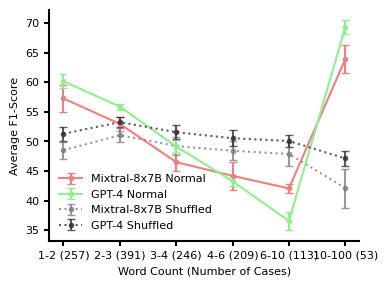

In [28]:
import logging
logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

import matplotlib.pyplot as plt
import matplotlib as mpl
# Define the color mapping with additional alpha for error bars
color_mapping = {
    'mixtral-8x7b-instruct_normal': ('lightcoral', 'mistyrose'),
    'mixtral-8x7b-instruct_shuffled': ('gray', '#d4e4f4'),  # Dark blue
    'gpt-4-1106-preview_normal': ('lightgreen', 'palegreen'),
    'gpt-4-1106-preview_shuffled': ('#333333', '#d6e5f5')  # Slightly different blue
}

# Define line styles for each condition
line_styles = {
    'mixtral-8x7b-instruct_normal': '-',      # solid
    'mixtral-8x7b-instruct_shuffled': ':',    # dotted
    'gpt-4-1106-preview_normal': '-',         # solid
    'gpt-4-1106-preview_shuffled': ':'       # dash-dot
}
legend_map = {
    'mixtral-8x7b-instruct Normal': 'Mixtral-8x7B Normal',
    'mixtral-8x7b-instruct Shuffled': 'Mixtral-8x7B Shuffled',
    'gpt-4-1106-preview Normal': 'GPT-4 Normal',
    'gpt-4-1106-preview Shuffled': 'GPT-4 Shuffled'
}
with mpl.rc_context(fname=".matplotlibrc"):
    # Bins and labels
    bins_custom_2 = [1, 2, 3, 4, 6, 10, 100]
    bin_cases = [257, 391, 246, 209, 113, 53]
    bin_labels = [f'{bins_custom_2[i]}-{bins_custom_2[i+1]} ({bin_cases[i]})' for i in range(len(bins_custom_2) - 1)]

    subset_normal = df_final[df_final['Bin Type'] == 'custom_1_words']
    subset_shuffled = df_final[df_final['Bin Type'] == 'custom_1_words_shuffled']

    models = subset_normal['Model'].unique()

    fig, ax = plt.subplots(figsize=(4, 3))

    for model in models:
        # Filter data for current model
        model_data_normal = subset_normal[subset_normal['Model'] == model]
        model_data_shuffled = subset_shuffled[subset_shuffled['Model'] == model]

        # Calculate statistics
        avg_f1_scores_normal = model_data_normal.groupby('Bin Number')['F1-Score'].agg(['mean', 'sem']).reset_index()
        avg_f1_scores_shuffled = model_data_shuffled.groupby('Bin Number')['F1-Score'].agg(['mean', 'sem']).reset_index()

        # Get model colors and line styles
        model_key_normal = f'{model.lower()}_normal'
        model_key_shuffled = f'{model.lower()}_shuffled'

        # Plot normal data with error bars
        ax.errorbar(avg_f1_scores_normal['Bin Number'], 
                    avg_f1_scores_normal['mean'] * 100, 
                    yerr=avg_f1_scores_normal['sem'] * 100, 
                    marker='o', 
                    markersize=3,
                    linestyle=line_styles[model_key_normal], 
                    color=color_mapping[model_key_normal][0], 
                    label=f'{model} Normal',
                    capsize=3,
                    zorder=2)

        # Plot shuffled data with error bars
        ax.errorbar(avg_f1_scores_shuffled['Bin Number'], 
                    avg_f1_scores_shuffled['mean'] * 100, 
                    yerr=avg_f1_scores_shuffled['sem'] * 100, 
                    marker='o', 
                    markersize=3,
                    linestyle=line_styles[model_key_shuffled], 
                    color=color_mapping[model_key_shuffled][0], 
                    label=f'{model} Shuffled',
                    capsize=3,
                    alpha=0.8,  # Slightly thicker for better visibility of patterns
                    zorder=2)

    # Customize plot
    ax.set_xticks(range(len(bin_labels)))
    ax.set_xticklabels(bin_labels)
    ax.set_xlabel('Word Count (Number of Cases)')
    ax.set_ylabel('Average F1-Score')
    #update legend as per legend_map
    handles, labels = ax.get_legend_handles_labels()
    print(handles, labels)
    ax.legend([handles[0], handles[2], handles[1], handles[3]], [legend_map[labels[0]], legend_map[labels[2]], legend_map[labels[1]], legend_map[labels[3]],], loc='lower left')

    # Save the plot
    #plt.savefig('word_length_shuffled.svg')
    plt.show()